In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_result_dataframe(dataset_name, model_name, path):
    results = []
    for i in range(10):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")
        results_val = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False).reset_index()
        alpha_list = results_val.alpha.tolist()
        best_models = results_val.model.tolist()

        results_test = pd.read_csv(path + f"test_fold_{i}.csv")
        for alpha, m in zip(alpha_list, best_models):
            best_model = results_test[((results_test.alpha == alpha) & (results_test.model == m))]
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model.bal_acc.values[0],
                "min_bal_acc" : best_model.min_bal_acc.values[0]
            })

    results = pd.DataFrame(results).groupby("alpha").mean().reset_index()
    return results

/tmp/ipykernel_32/3553609433.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_32/3553609433.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


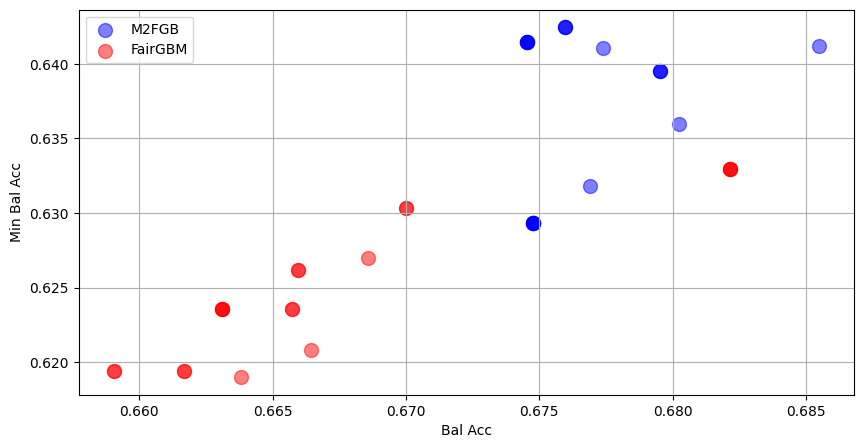

In [3]:
dataset_name = "german"
model_name = "M2FGB_grad"
n_groups = 2
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


/tmp/ipykernel_32/720781157.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_32/720781157.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


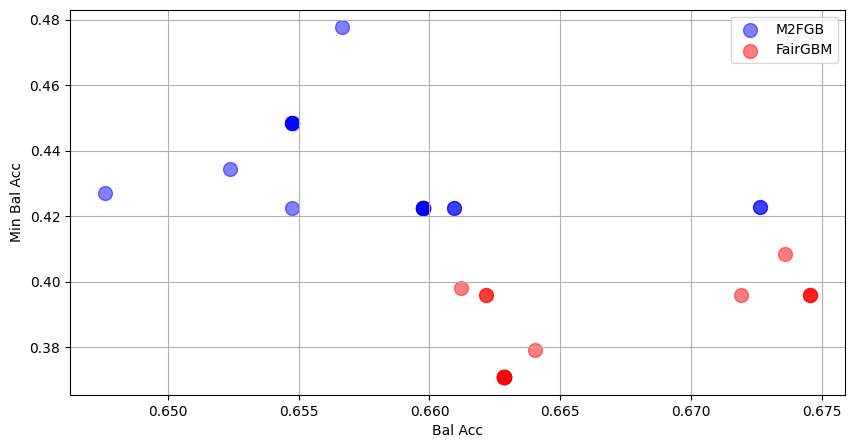

In [4]:
dataset_name = "german"
model_name = "M2FGB_grad"
n_groups = 4
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


/tmp/ipykernel_32/1905645427.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_32/1905645427.py:30: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


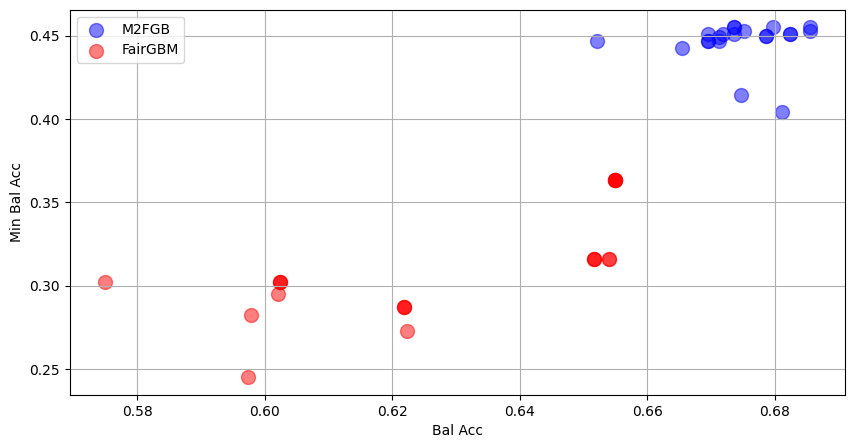

In [6]:
dataset_name = "german"
model_name = "M2FGB_grad"
n_groups = 8
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

model_name = "FairGBMClassifier"
path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
results_fairgbm = get_result_dataframe(dataset_name, model_name, path)


fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


/tmp/ipykernel_1433/1364808465.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(
/tmp/ipykernel_1433/1364808465.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin' will be ignored
  plt.scatter(


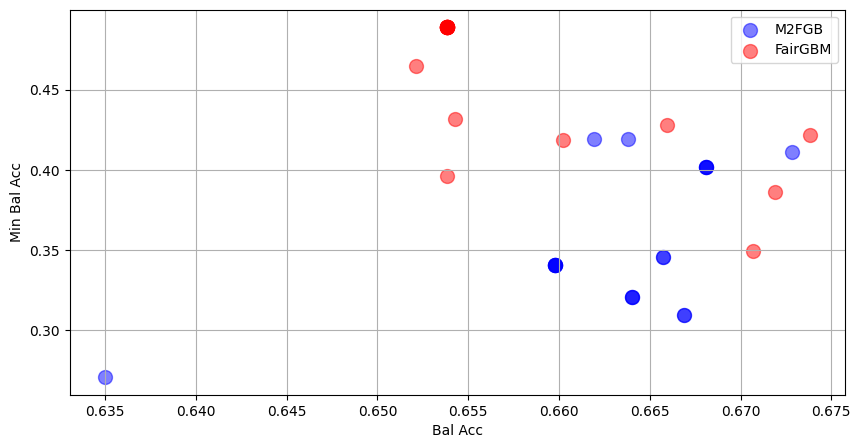

In [63]:
fig = plt.subplots(figsize = (10, 5))
#plt.subplot(1, 2, 1)
plt.scatter(
    results_m2fgb.bal_acc,
    results_m2fgb.min_bal_acc,
    c = "blue",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "M2FGB"
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid()

#plt.subplot(1, 2, 2)
plt.scatter(
    results_fairgbm.bal_acc,
    results_fairgbm.min_bal_acc,
    c = "red",
    s = 100,
    vmin = -0.5,
    alpha = 0.5,
    label = "FairGBM",
)

plt.legend()
plt.xlabel("Bal Acc")
plt.ylabel("Min Bal Acc")
plt.grid(True)
plt.show()


In [23]:
results = pd.DataFrame(results).groupby("alpha").mean().reset_index()

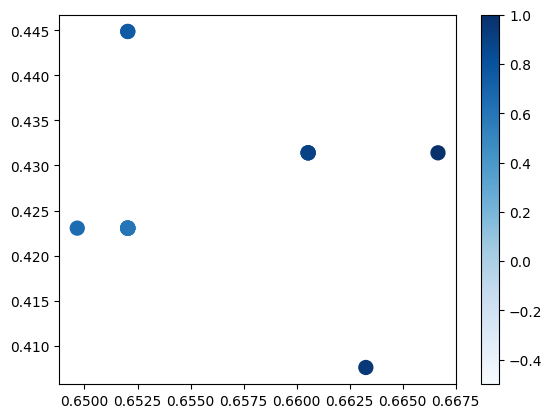

In [24]:
plt.scatter(
    results.bal_acc,
    results.min_bal_acc,
    c = results.alpha,
    cmap = "Blues",
    s = 100,
    vmin = -0.5,
)

plt.colorbar()

In [14]:
results

,fold,bal_acc,min_bal_acc
alpha,,,
0.00,4.5,0.635000,0.473540
0.05,4.5,0.664048,0.485206
0.10,4.5,0.664048,0.485206
0.15,4.5,0.664048,0.485206
0.20,4.5,0.666905,0.484842
0.25,4.5,0.666905,0.484842
0.30,4.5,0.659762,0.501509
0.35,4.5,0.659762,0.501509
0.40,4.5,0.659762,0.501509


In [3]:
results_val

,alpha,level_1,score,bal_acc,acc,roc,eq_loss,eod,spd,model,min_tpr,min_bal_acc
0,0.00,1995,0.680000,0.726190,0.79,0.792381,0.399540,0.14,0.208333,95,0.86,0.680000
1,0.05,1996,0.682310,0.726190,0.79,0.792381,0.399540,0.14,0.208333,95,0.86,0.680000
2,0.10,1997,0.684619,0.726190,0.79,0.792381,0.399540,0.14,0.208333,95,0.86,0.680000
3,0.15,1998,0.686929,0.726190,0.79,0.792381,0.399540,0.14,0.208333,95,0.86,0.680000
4,0.20,1999,0.689238,0.726190,0.79,0.792381,0.399540,0.14,0.208333,95,0.86,0.680000
5,0.25,2000,0.691548,0.726190,0.79,0.792381,0.399540,0.14,0.208333,95,0.86,0.680000
6,0.30,132,0.694841,0.747619,0.82,0.808571,0.386211,0.10,0.208333,6,0.90,0.672222
7,0.35,133,0.698611,0.747619,0.82,0.808571,0.386211,0.10,0.208333,6,0.90,0.672222
8,0.40,134,0.702381,0.747619,0.82,0.808571,0.386211,0.10,0.208333,6,0.90,0.672222
9,0.45,135,0.706151,0.747619,0.82,0.808571,0.386211,0.10,0.208333,6,0.90,0.672222


In [8]:
# for each alpha value, get model with highest score
r = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False)



In [10]:
r

,,score,bal_acc,acc,roc,eq_loss,eod,spd,model
alpha,,,,,,,,,
0.0,1034,0.626667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.1,1035,0.630667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.2,1036,0.634667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.3,1037,0.638667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.4,1038,0.642667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.5,1039,0.646667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.6,1040,0.650667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.7,1041,0.654667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94
0.8,1042,0.658667,0.666667,0.60,0.765238,3.160150,0.413333,0.416667,94


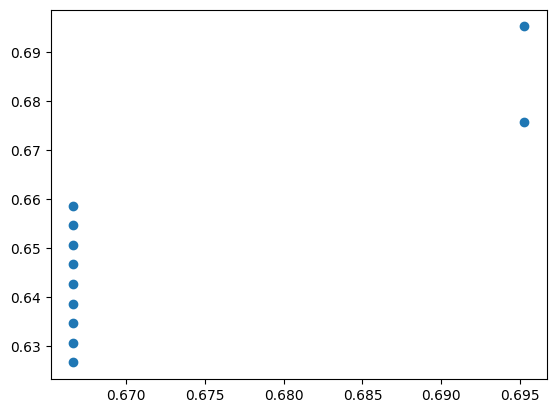

In [11]:
plt.scatter(r.bal_acc, r.score)